In [1]:
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
import os
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

figure_params.set_rc_params()
figure_params.setup_directories()

SUBFIG_DIR = Constants.FIG_FOLDER + 'fig3/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

#run simulations for figure, will take a while to run
# import subprocess
# os.chdir(Constants.PROJ_DIR)
# subprocess.run(["bash", "simulation/fig_simulations/fig3_sims.sh"]) #uncomment code to make datasets if not made yet

import warnings
warnings.filterwarnings("ignore")


In [2]:
reps = Constants.UNIS
seeds = Constants.SEEDS
smooth = True
moveset = dt.get_moveset(reps[0])
abr_dict = Constants.REPERTOIRE_ABR_DICTS[moveset]

#### Model output after adaptation

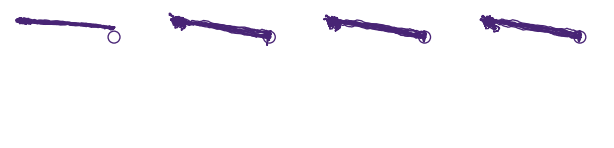

In [3]:
g, params = dt.graph_outputs_all(Constants.SEED_EX, 'uni_rad', reps, 
    perturbation = 'rotation', pert_param = 10.0 ,pert_set = 'v1')
plt.savefig(SUBFIG_DIR + "output_" + params +'.pdf', format='pdf')

#### Loss during adaptation

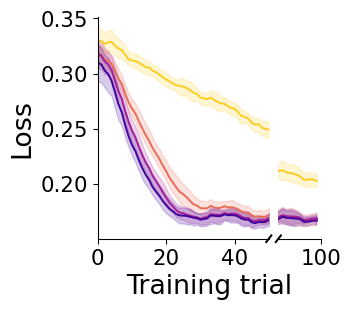

In [4]:
_, _, params= dt.graph_loss_broken_axis(seeds, 'uni_rad', reps, 'rotation', 10.0, 'v1', smooth=smooth, rel_loss = False)

plt.savefig(SUBFIG_DIR + "loss_"+params+".pdf", format='pdf', bbox_inches='tight')


#### Fit exponential curves to loss curves during adaptation

In [5]:
#exponential function
def exp_func(t, A, K, C):
    return A * np.exp(K * t) + C

smooth = True
learn_set = None
perturbation = 'rotation'
pert_param = 10.0
pert_set = 'v1'

reps = Constants.UNIS

rows_list = []
colormap = dt.get_colormap(reps, 'plasma_r')
for sim_set in ['uni_rad']:
    for seed in seeds:
        for repertoire in reps:

            # decay constant
            try:
                loss = dt.get_loss(seed, sim_set, repertoire, perturbation, pert_param, pert_set, smooth = smooth)
            except:
                print('failed', seed, sim_set, repertoire)
                continue
            t = np.arange(1,len(loss)+1)
            ## exponential fit
            p0 = (0.1,-0.1,0.2) # starting search koefs
            opt, pcov =  scipy.optimize.curve_fit(exp_func, t, loss, p0)
            A, K, C = opt
            fit_y = exp_func(t, A, K, C)

            # relative weight change
            outdir = dt.get_outdir(seed, sim_set, repertoire, perturbation, pert_param, pert_set)
            init_weights = dt.get_model_weights(outdir,before_training=True)['rec']
            dws = dt.get_weight_changes(outdir)['rec']
            rel_dw = dt.rel_dw(dws, init_weights)
            rel_dw_med_abs = np.median(np.abs(rel_dw))

            temp = {
                'seed': seed,
                'sim_set': sim_set,
                'repertoire': repertoire,
                'perturbation': perturbation,
                'pert_param': pert_param,
                'pert_set': pert_set,
                'decay': K,
            }
            rows_list.append(temp)

df = pd.DataFrame(rows_list)


#### Plot decay rate

ShapiroResult(statistic=0.8410163377788806, pvalue=0.04537859047495206)
decay 	 1 Mov. 	 2 Mov. 	 2.130385217303654e-10
ShapiroResult(statistic=0.8410163377788806, pvalue=0.04537859047495206)
decay 	 1 Mov. 	 3 Mov. 	 2.775471222367868e-10
ShapiroResult(statistic=0.8410163377788806, pvalue=0.04537859047495206)
decay 	 1 Mov. 	 4 Mov. 	 1.4989670265146193e-09
ShapiroResult(statistic=0.893001851745035, pvalue=0.1832563149321222)
decay 	 2 Mov. 	 3 Mov. 	 5.351829339524469e-06
ShapiroResult(statistic=0.893001851745035, pvalue=0.1832563149321222)
decay 	 2 Mov. 	 4 Mov. 	 6.411937916858163e-07
ShapiroResult(statistic=0.9675986662593229, pvalue=0.8677315675974464)
decay 	 3 Mov. 	 4 Mov. 	 0.028760204059884303




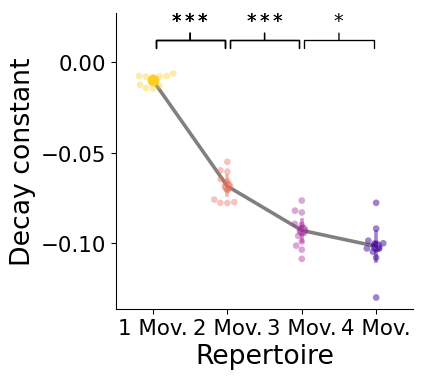

In [7]:
y = 'decay'

plt.figure(figsize=(4,4))
colors = Constants.REPERTOIRE_COLORS            
g = sns.swarmplot(x="repertoire", y=y, data=df, palette = colors, alpha = 0.4, marker = 'o')
g = dt.pointplot_across_repertoires(df, reps, y, 'grey', 'solid', ax = g)
ymin, ymax = g.get_ylim()
g.set_ylim([None, ymax+(ymax-ymin)*0.2])

#stats 
for i, rep1 in enumerate(reps):
    for j, rep2 in enumerate(reps[i+1:]):
        a = df[(df.repertoire == rep1)]
        b = df[(df.repertoire == rep2)]
        a_measure = a[y].values
        b_measure = b[y].values

        print(scipy.stats.shapiro(a_measure))
        _, pnorm = scipy.stats.ttest_rel(a_measure, b_measure)
        text = dt.get_signif_annot(pnorm)

        print(y, '\t', abr_dict[rep1], '\t', abr_dict[rep2], '\t', pnorm)
        g.annotate(text, xy=((i+1)*0.25, 0.9), xytext=((i+1)*0.25, 0.95), xycoords='axes fraction', fontsize = 'x-large',ha='center', va='bottom',arrowprops=dict(arrowstyle='-[, widthB=1.8, lengthB=0.4', lw=1))

print('\n') 

# set ordering
plt.setp(g.lines[:2], zorder=0)
plt.setp(g.lines[4:6], zorder=0)
plt.setp(g.collections[3], alpha=.5)
plt.setp(g.lines[5:], alpha=.5)
plt.ylabel('Decay constant')
# plt.ylim([-0.15,0])

params = '_'.join(filter(None, [perturbation, pert_set, str(pert_param) if pert_param else None]))
plt.savefig(SUBFIG_DIR + "decay_constant.pdf", format='pdf', bbox_inches='tight')
#normal